In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import imp # for reloading modules

import helper as h

%matplotlib inline

In [136]:
imp.reload(h)

<module 'helper' from '/Users/dirkkalmbach/Library/Mobile Documents/com~apple~CloudDocs/Projekte/DSND/blog-project/helper.py'>

# Problem Understanding
## Definition of Target Group(s)
The aim of this Report is to find out how Data Scientists can work independently, i.e. as Freelancer, independent contractor, or 1-person-company.
I will use the following abbreviations:
> - `Pure Data Scientists` (PDS): Data Scientists, who consider himself/herself as **only** _Data Scientists / Machine Learning Specialists_
> - `Data Scientist` (DS): Respndents who consider him/herself as *Data Scientist*, but **not only**. 
> - `Data Jobs` (DJ): 
_Data Scientists_ 👆🏻, and/or _Data/Business Anaylsts_ and/or _Data Engineers_, i.e.: Respondents who did not mark any other "

## Data Science Question 
1. Are independent Data Scientists more happy with their Job than employed Data Scientists?
2. Do indpeendent Data Scientists earn more than employed Data Scientists?
3. What Coding Languages use Data Scientists? Is here any development over time?
...
4. What makes Developer in general happier? (also DevType as Dummy)

# Data Understanding

## Load Data

In [2]:
#TODO: refactor: unzip_dataframe() in helper

# Load survey 2019 dataset (unzip first)
file = "data/raw data/developer_survey_2019/survey_results_public.csv"

from zipfile import ZipFile

zip_file = ZipFile('data/raw data/developer_survey_2019/survey_results_public.csv.zip')
df = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}
df = df["survey_results_public.csv"]

# Load data description
schema = pd.read_csv("data/raw data/developer_survey_2019/survey_results_schema.csv")

h.df_info(df)

Rows: 88883 	 Variables: 85 	 	 Size: n/a kb


## Definition of Target Group(s)

In [3]:
h.get_desc("Employment")

'Which of the following best describes your current employment status?'

In [4]:
# Im only interested in full working people -> no parttime, students, etc.
df = df[(df["Employment"]=='Employed full-time') | (df["Employment"]=='Independent contractor, freelancer, or self-employed')]
h.df_info(df)

Rows: 72951 	 Variables: 85 	 	 Size: n/a kb


In [5]:
# TODO: überarbeiten

# Freelancing is asked 2x -> I wonder if there are some mismatches
df[ (df["Employment"]=='Independent contractor, freelancer, or self-employed') & (
     df["OrgSize"]== "Just me - I am a freelancer, sole proprietor, etc.")
  ].shape

df[df["Employment"]=='Independent contractor, freelancer, or self-employed'].shape
df[df["OrgSize"]== "Just me - I am a freelancer, sole proprietor, etc."].shape

(3817, 85)

#### How many "Pure" Data Scientists are in the dataset?

In [8]:
PDS = df[df["DevType"]=="Data scientist or machine learning specialist"]
h.df_info(PDS)

Rows: 494 	 Variables: 85 	 	 Size: n/a kb


_...and how many among them are Freelancer?_

In [9]:
# How many Freelance Pure Data Scientists?
h.df_info(
    PDS[PDS["Employment"]=="Independent contractor, freelancer, or self-employed"]
)

Rows: 25 	 Variables: 85 	 	 Size: n/a kb


Wow! 😱 Only 25 Cases! Of course, this is not enough for any valuable insights 😫

#### Group Data related Jobs

In [10]:
#TODO: Refactor with this
    #df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

DJ=["Data scientist or machine learning specialist", "Data or business analyst", "Engineer, data"]
RS=["Academic Research","Scientist"]
DS=["Data scientist or machine learning specialist"]

def t(col, jobs, cat):
    found=False
    for job in jobs:
        if job in col:
            found=True
    if found:
        return cat
    else:
        return np.nan
            
            
# Science Jobs
df["Job_RS"]=df["DevType"].apply(lambda x: t(str(x),RS,"Something with Science"))

# Data Jobs
df["Job_DJ"]=df["DevType"].apply(lambda x: t(str(x),DJ,"Something with Data"))

# Data Scientists
df["Job_DS"]=df["DevType"].apply(lambda x: t(str(x),DS,"Data Scientist"))

# Print Results
print("Data Scientist (n): {} (NaN: {})".format( df.Job_DS.count(), df.Job_DS.isna().sum()) )
print("Something with Data: {} (NaN: {})".format( df.Job_DJ.count(),  df.Job_DJ.isna().sum()) )
print("Something with Science (n): {} (NaN: {})".format( df.Job_RS.count(), df.Job_RS.isna().sum()) ) 

Data Scientist (n): 5436 (NaN: 67515)
Something with Data: 12160 (NaN: 60791)
Something with Science (n): 2984 (NaN: 69967)


> 🤓 The 3 new build variables are not exclusive, i.e.: somebody who marked herself as Data Scientist, Business Analyst, and Scientist would be in all three groups!

Let's put this all in one variable TargetGroups with these categories:
- PDS
- DS
- DJ

In [30]:
# create new var 'TargetGroup'
df.loc[df['Job_DJ'] == "Something with Data", 'TargetGroup'] = 'Something with Data'
df.loc[df['Job_RS'] == "Something with Science", 'TargetGroup'] = 'Something with Science'
df.loc[df['Job_DS'] == "Data Scientist", 'TargetGroup'] = 'Data Scientist'

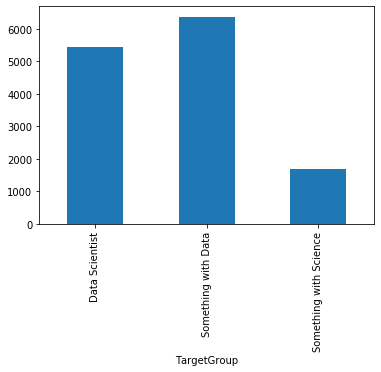

In [35]:
df.groupby("TargetGroup").count().Respondent.plot.bar()

## Job Satisfaction

How happy are Data Scientists with their job?

In [37]:
# Question in Survey 2019
h.get_desc("JobSat")

'How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)'

In [38]:
# build jobsatisfaction index (1-5)

index = {'Slightly satisfied': 4, 
         'Slightly dissatisfied': 2,
         'Neither satisfied nor dissatisfied': 3,
         'Very satisfied': 5,
         'Very dissatisfied': 1,
         np.nan: np.nan
        }

df["JobSatIndex"] = df["JobSat"].apply(lambda x: index[x])

print("Avg Job Satisfaction: ", df.JobSatIndex.mean().round(2))  

Avg Job Satisfaction:  3.69


#### Job Satisfaction between Freelancer and Employed

In [39]:
df.groupby('Employment') \
       .agg(n=('Employment', 'size'), Job_Satisfaction=('JobSatIndex', 'mean')).reset_index()

,Employment,n,Job_Satisfaction
0,Employed full-time,64440,3.684898
1,"Independent contractor, freelancer, or self-em...",8511,3.713764


> ❗__Interesting__: no difference between Freelancer and employed

#### Job Satisfaction between Data Jobs

In [40]:
df.groupby('TargetGroup') \
       .agg(n=('TargetGroup', 'size'), Job_Satisfaction=('JobSatIndex', 'mean')).reset_index()

,TargetGroup,n,Job_Satisfaction
0,Data Scientist,5436,3.773581
1,Something with Data,6383,3.668349
2,Something with Science,1695,3.828402


> ❗only slight differences, but the direction looks right: Scientists are more happier than Data Jobber